<a href="https://colab.research.google.com/github/DiegoLeonG96/Tarea2_MLA/blob/main/Tarea_2_MLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Profesor: Tomás Fontecilla </em><br>
    <em>Curso: Machine Learning Avanzado </em><br>

</div>


# Tarea 2: Red Neuronal Convolucional
**Integrantes**:
- Kurt Castro
- Diego León
- Cristian Pizarro

## 1. Introducción

Las redes neuronales convolucionales se han consolidado como una herramienta de amplio uso en múltiples industrias gracias a su capacidad de procesar datos visuales, siendo utilizado ya sea para el desarrollo de vehículos autónomos, sistemas de reconocimiento facial, procedimientos de control de calidad (clasificando la producción según estado u otra característica), entre muchos otros.

En el presente trabajo utilizaremos la base de datos ‘Muffin vs Chihuahua’ disponibilizada en Kaggle por Shreyas Mocherla. Esta contiene, como su nombre lo indica, imágenes de Muffins y Chihuahuas, las cuales son visualmente muy similares. El desafío que se propone es precisamente desarrollar un modelo de clasificación que logre sortear estas semejanzas o patrones que no son claramente distinguibles.  


## 2. Objetivo

El objetivo principal será generar un modelo de clasificación basado en redes neuronales convolucionales que logre clasificar correctamente las imágenes en Chihuahas o Muffins.

Los objetivos secundarios serán asegurar un correcto procesamiento y balance de los datos, así como también garantizar la mejor precisión, ajuste y desempeño general posible mientras controlamos su estabilidad.


## 3. Metodología utilizada

Con el fin de cumplir con los objetivos definidos, se generó una serie secuencial de modelos en base a redes neuronales convolucionales, los cuales sufrieron modificaciones tanto en su estructura como en hiperparámetros. Estos ajustes se realizaron ya sea en función de los problemas observados o con la finalidad de buscar un mejor rendimiento.
Adicionalmente, se generó un modelo de Perceptrón Multicapa como punto de partida, con el objetivo de comparar el rendimiento de estos dos tipos de modelos para el procesamiento de imágenes.   

Los modelos fueron evaluados inicialmente a través de su precisión, de la evolución de sus funciones de pérdida, de su ajuste y estabilidad (comparativa de precisión y ajuste en entrenamiento y testeo). Y dado que este es un ejercicio de clasificación, se consideró de manera complementaria el área bajo la curva de los modelos (AUC).

A continuación se describen los modelos y criterios definidos, los cuales como punto de partida consideran un learning rate de 0.01, batch size de 32 y una función de 'early stopping' que detendrá el entrenamiento del modelo cuando las épocas muestren un empeoramiento en la pérdida de validación y, adicionalmente, restaurará los pesos del mejor modelo registrado:

1.   **Perceptrón Multicapa:** Como punta de partida general se presenta un modelo de perceptrón multicapa con una primera capa configurada con una función de activación 'ReLU' y una capa de salida con activación sigmoide (utilizada para clasificación binaria).

2.   **Red Neuronal convolucional 1:** Como punto de partida para los modelos convolucionales, se definen 4 capas convolucionales con activación 'ReLU', con un aplanado de datos y posteriormente, 1 capa densa con activación ReLu, finalizando con la capa densa de salida con activación sigmoide (dado que la clasificación es binaria). Este primer modelo mostró un grave problema de sobreajuste y también de ruido, que se ajustará en las siguientes instancias.  

3.   **Red Neuronal convolucional 2:** Para controlar el sobreajuste, en éste se añade una técnica de regulariación por Dropout en cada capa de la estructura, siendo de 0.25 antes del aplanado y de 0.5 después del aplanado.

4.   **Red Neuronal convolucional 3:** Este tercer modelo fue ajustado en función de controlar el ruido y mejorar la estabilidad del modelo. El principal problema que mostraba el modelo anterior es que la precisión y la pérdida de los datos de validación tenian una alta volatilidad a través de las épocas. Por este motivo, se modificó el hiperparámetro de learning rate en la compilación, pasando de 0.01 a 0.0001. Adicionalmente, se modificó el batch size, pasando de 32 a 512. La paciencia de la función 'Early stopping' se aumentó a 20, dado que una tasa menor de aprendizaje hace que el modelo tarde más en aprender.


5.   **Red Neuronal convolucional 4:** Éste modelo se desarrolló con el objetivo de empujar aún más la corrección del "sobreajuste" (el cual es muy ligero). Para ello simplemente se redujo el número de capas convolucionales, de 4 a 3.

6.   **Red Neuronal convolucional 5:** Se continuó intentando mejorar el ajuste, pero esta vez a través de un segundo método de regularización, añadiendo regularización L2 a la estructura. Se utiliza un valor muy bajo (0.0001), dado que el sobreajuste es muy ligero, y por el hecho de que queremos evitar empeorar la pérdida (valores más altos efectivamente aumentan la pérdida, tanto en entrenamiento como en validación).

  
7.   **Red Neuronal convolucional 6:** Se intenta aumentar aún más la precisión del modelo y el rendimiento general. Para ello nos preguntamos si los contornos de las imágenes nos proporcionarían información relevante. Bajo este objetivo e interrogante se añadió el parámetro de 'padding' en la estructura de la red.

8. **Red Neuronal convolucional 7:** Finalmente, se busca reducir totalmente los efectos de overfitting observados en modelos anteriores. Para lo anterior, se utiliza una estrategia de **data augmentation** que puede rotar, desplazar y hacer zoom en cada imagen para lograr un mejor nivel de generalización.

  

## 4.  Carga y Preprocesamiento de Datos

Primero que todo, se cargan las librerías necesarias y se establecen semillas que serán utilizadas posteriormente en los modelos:

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras import models, layers, optimizers, regularizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
import matplotlib.pyplot as plt
import random
import kagglehub
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Establecemos semillas (Python, Numpy, Tensorflow)
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

Configuramos el uso de GPU:

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Se encontró GPU: {gpus}")
else:
    print("No se encontró GPU. Asegúrate de haber activado el entorno con GPU en Colab.")

Se encontró GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Descargamos la base de datos y la guardamos:

In [3]:
path = kagglehub.dataset_download("samuelcortinhas/muffin-vs-chihuahua-image-classification")
print("Path to dataset files:", path)

100%|██████████| 474M/474M [00:06<00:00, 77.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification/versions/2


In [4]:
base_path = "/root/.cache/kagglehub/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification/versions/2"

Definimos nuestros datos de entrenamiento y testeo. Posteriormente éstos se procesan:

In [5]:
# Entrenamiento y testeo
train_dir = f'{base_path}/train'
test_dir = f'{base_path}/test'

batch_size = 32
num_classes = 2

image_size = (150, 150)
input_shape = (150, 150, 3)

# Cargamos los datos
X_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    batch_size=batch_size
)

X_test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    batch_size=batch_size
)

# Procesamos los datos
X_train, y_train = [], []
for images, labels in X_train_ds:
    X_train.append(images.numpy())
    y_train.append(labels.numpy())

X_test, y_test = [], []
for images, labels in X_test_ds:
    X_test.append(images.numpy())
    y_test.append(labels.numpy())

# Combinamos los datos en arreglos numpy
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train).ravel()
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test).ravel()

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Found 4733 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.
X_train shape: (4733, 150, 150, 3), y_train shape: (4733,)
X_test shape: (1184, 150, 150, 3), y_test shape: (1184,)


Correspondencia de clases

Valor 0, corresponde a chihuahuas

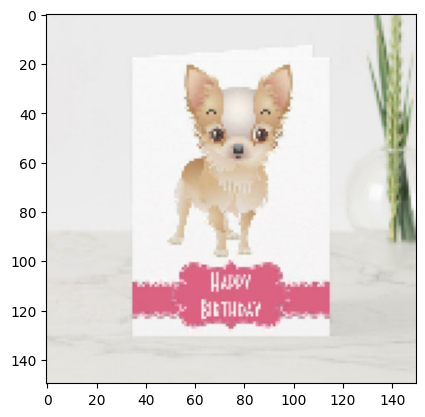

In [7]:
plt.imshow(X_train[y_train==0][0, : ,: ,:]/255)
plt.show()

Valor 1, corresponde a muffins

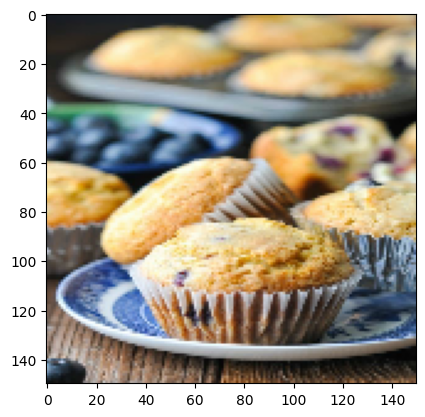

In [8]:
plt.imshow(X_train[y_train==1][0, : ,: ,:]/255)
plt.show()

Finalmente, verificamos el balance de nuestros datos:

In [ ]:
train_class_counts = Counter(y_train)
test_class_counts = Counter(y_test)

print("Distribución de clases en el conjunto de entrenamiento:")
total_train = sum(train_class_counts.values())
for cls, count in train_class_counts.items():
    proportion = count / total_train * 100
    print(f"Clase {int(cls)}: {count} muestras ({proportion:.2f}%)")

print("\nDistribución de clases en el conjunto de prueba:")
total_test = sum(test_class_counts.values())
for cls, count in test_class_counts.items():
    proportion = count / total_test * 100
    print(f"Clase {int(cls)}: {count} muestras ({proportion:.2f}%)")

Distribución de clases en el conjunto de entrenamiento:
Clase 1: 2174 muestras (45.93%)
Clase 0: 2559 muestras (54.07%)

Distribución de clases en el conjunto de prueba:
Clase 0: 640 muestras (54.05%)
Clase 1: 544 muestras (45.95%)


Se observa un correcto balance en los datos, por lo cual no es necesario aplicar alguna estrategia de balanceo de clases y podemos proceder con los siguientes pasos.

## 5. Aplicación de Modelos

## MLP (Multilayer Perceptron)

Como punto de partida generamos un modelo de perceptron multicapa, el cual será utilizado para realizar una comparativa general del rendimiento que obtiene éste tipo de modelo en contraste al convolucional, el cual sería el más apropiado para el procesamiento de imágenes.

La estructura del modelo cuenta con una capa densa configurada con una función de activación ReLU. Luego se encuentra la capa de salida que cuenta con una función de activación sigmoide, la cual es lo más apropiado para tareas de clasificación binaria.

El modelo se compila con un learning rate de 0.01. Se entrena con un batch size de igual a 32. Y se utiliza una regularización de Early Stopping basado en la pérdida de validación, con el fin de detener el entrenamiento cuando ésta métrica empeore a lo largo de las épocas. Cabe mencionar éste método de regularización se configura con el parámetro 'restore_best_weights' para que restaurar los pesos relacionados al modelo con el mejor desempeño.

In [ ]:
# Dimensiones originales de las imágenes
num_samples, height, width, channels = X_train.shape

# Aplanamos las imágenes para que el modelo pueda procesarlas
X_train_flattened = X_train.reshape(num_samples, height * width * channels)

# Aplanamos el conjunto de pruebas
X_test_flattened = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2] * X_test.shape[3])

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5682 - loss: 16490.1152 - val_accuracy: 0.6166 - val_loss: 1931.2512
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6322 - loss: 1424.4861 - val_accuracy: 0.6698 - val_loss: 170.5494
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7224 - loss: 80.3046 - val_accuracy: 0.6334 - val_loss: 4.7911
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6201 - loss: 1.1568 - val_accuracy: 0.6782 - val_loss: 0.6878
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7129 - loss: 0.6188 - val_accuracy: 0.7078 - val_loss: 0.6212
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7545 - loss: 0.5464 - val_accuracy: 0.7196 - val_loss: 0.6251
Epoch 7/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7602 - loss: 0.5249 - val_accuracy: 0.7247 - val_loss: 0.6234
Epoch 8/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7705 - loss: 0.

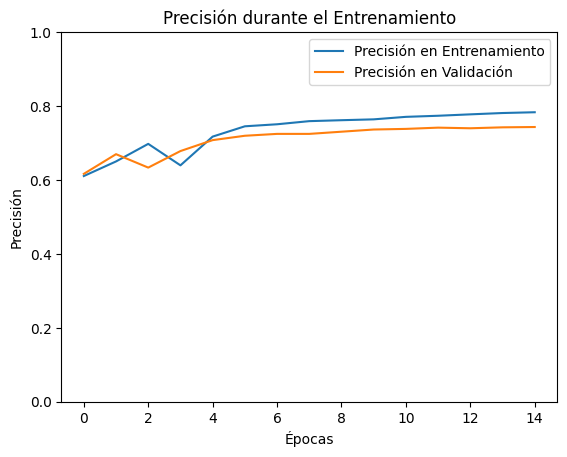

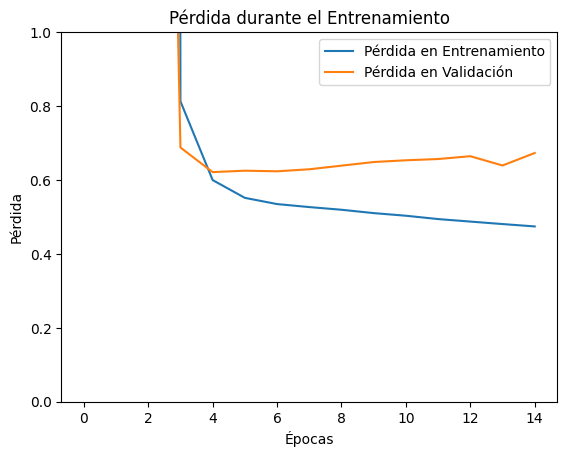

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
AUC del modelo: 0.7329


In [ ]:
# Definimos la estructura
hidden_units = 128
batch_size = 32
lr = 1e-2
model_mlp = Sequential([
    Dense(hidden_units, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed)),
    Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+1))
])

# Compilamos
model_mlp.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=lr),
              metrics=['accuracy'])

#Entrenamos
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model_mlp.fit(X_train_flattened, y_train,
                    epochs=100,
                    batch_size=batch_size,
                    validation_data=(X_test_flattened, y_test),
                    callbacks=[early_stopping])

# Evaluamos el modelo
train_acc=model_mlp.evaluate(X_train_flattened, y_train, batch_size=batch_size)[1]
test_acc=model_mlp.evaluate(X_test_flattened, y_test, batch_size=batch_size)[1]
print(f'Training accuracy: {train_acc:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

# Graficamos la precisión
plt.plot(history.history['accuracy'], label='Precisión en Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.ylim(0, 1)
plt.legend()
plt.title('Precisión durante el Entrenamiento')
plt.show()

# Graficamos la pérdida
plt.plot(history.history['loss'], label='Pérdida en Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.ylim(0, 1)
plt.legend()
plt.title('Pérdida durante el Entrenamiento')
plt.show()

# Evaluamos el modelo con AUC
y_pred_prob = model_mlp.predict(X_test_flattened)
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC del modelo: {auc:.4f}")

Los resultados en general no muestran malos resultados, obtiendo una precisión de 0.73 para los datos de entrenamiento y de 0.70 para los de validación. A pesar de que la pérdida tampoco muestra un mal ajuste, sí se observa un poco de inestabilidad, lo que uno podría plantearse en mejorar.

Por otro lado, el Área Bajo la Curva del modelo es de 0.73, lo cual indica un correcto rendimiento, aunque con bastante espacio de mejora.

**Matriz de Confusión y Classification Report**

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


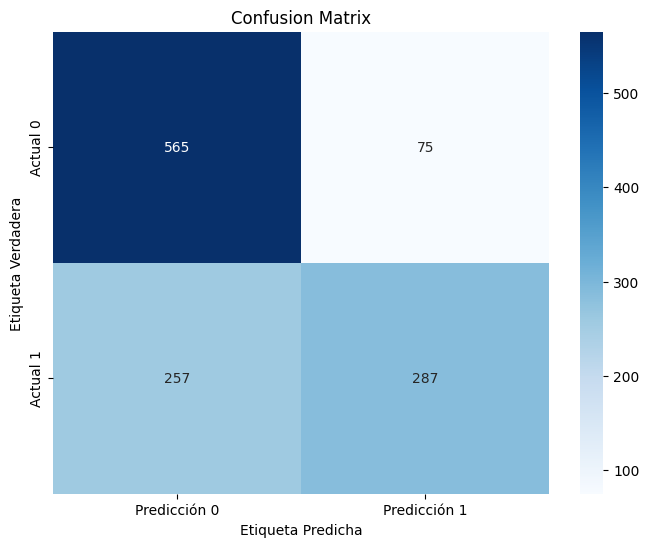

              precision    recall  f1-score   support

         0.0       0.69      0.88      0.77       640
         1.0       0.79      0.53      0.63       544

    accuracy                           0.72      1184
   macro avg       0.74      0.71      0.70      1184
weighted avg       0.74      0.72      0.71      1184



In [ ]:
# Predicción sobre test
y_pred = model_mlp.predict(X_test_flattened)
y_pred_classes = (y_pred > 0.5).astype(int) # Convertimos probabilidades a clases
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)

# Plot matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicción 0', 'Predicción 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()

# Imprimir classification report
print(classification_report(y_test, y_pred_classes))

Este modelo, tiene menor tasa de error en la clase 0, la cual corresponde a chihuahuas.
Al mismo tiempo, podemos ver que para la clase 1 (muffins) presenta un recall del 53% lo cual se condice con la matriz de confusión.

## Red Neuronal Convolucional 1

A partir de este punto, se comenzarán a desarrollar una serie de modelos convolucionales, los evaluaremos y propondremos mejoras a partir de los resultados obtenidos.

En general, se mantendrán los mismos parámetros establecidos para el modelo anterior: Mismos parámetros de compilación, mismo batch size y el mismo criterio de regularización con Early Stopping.

Para este primer modelo se propuso una estructura que cuenta con 4 capas convolusionales configuradas con una función de activación ReLU, las cuales progresivamente van aumentando el número de filtros (desde 32 en la primera capa hasta 256 en la cuarta). Posteriormente se realiza un aplanado de los datos, se genera una capa densa con una función de activación ReLU, y finaliza con una capa de salida que cuenta con una función de activación sigmoide.

In [ ]:
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+2)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+4)),
    BatchNormalization(),

    Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+5))
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_cnn.compile(loss='binary_crossentropy',
             optimizer = Adam(learning_rate=1e-2),
             metrics=['accuracy'])

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.7767 - loss: 0.5924 - val_accuracy: 0.7306 - val_loss: 0.7782
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.8754 - loss: 0.3232 - val_accuracy: 0.7779 - val_loss: 0.6853
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8895 - loss: 0.2669 - val_accuracy: 0.8252 - val_loss: 0.4572
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9206 - loss: 0.2073 - val_accuracy: 0.5084 - val_loss: 2.6338
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9317 - loss: 0.1765 - val_accuracy: 0.7492 - val_loss: 0.9279
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9463 - loss: 0.1488 - val_accuracy: 0.8294 - val_loss: 0.7686
Epoch 7/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9515 - loss: 0.1304 - val_accuracy: 0.6199 - val_loss: 1.8498
Epoch 8/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9396 - loss: 0.1471 

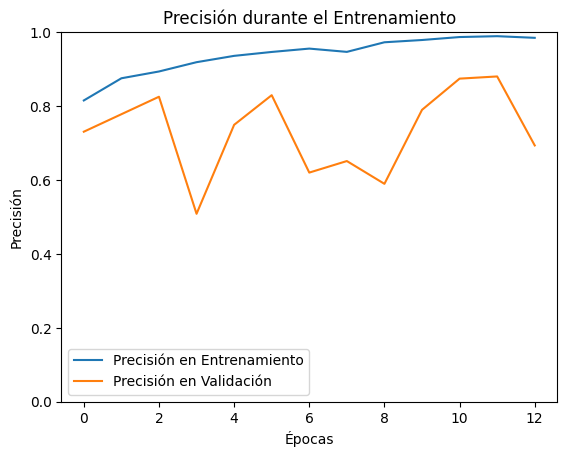

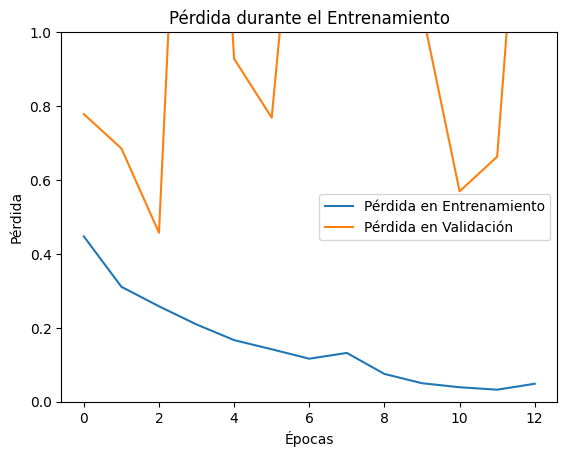

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
AUC del modelo: 0.9293


In [ ]:
batch_size = 32
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_cnn.fit(
X_train, y_train,
batch_size=batch_size,
epochs=100,
verbose = 1,
validation_data=(X_test, y_test),
callbacks=[early_stopping]
)

# Evaluamos el modelo
train_acc=model_cnn.evaluate(X_train, y_train, batch_size=batch_size)[1]
test_acc=model_cnn.evaluate(X_test, y_test, batch_size=batch_size)[1]
print(f'Training accuracy: {train_acc:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

# Graficamos la precisión
plt.plot(history.history['accuracy'], label='Precisión en Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.ylim(0, 1)
plt.legend()
plt.title('Precisión durante el Entrenamiento')
plt.show()

# Graficamos la pérdida
plt.plot(history.history['loss'], label='Pérdida en Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.ylim(0, 1)
plt.legend()
plt.title('Pérdida durante el Entrenamiento')
plt.show()

# Evaluamos el modelo con AUC
y_pred_prob = model_cnn.predict(X_test)
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC del modelo: {auc:.4f}")

A primera vista este modelo cuenta con un excelente rendimiento en precisión (0.83 en entrenamiento) y un buen rendimiento de acuerdo al AUC (0.93). Sin embargo, si cuando observamos los gráficos comparativos entre la precisión y pérdida de los datos de entrenamiento y validación, observamos que existe un gran sobreajuste en muchas de las épocas, y un exceso de ruido a través de éstas. Por lo que se hace necesario corregir estos dos aspectos.

**Matriz de Confusión y Classification Report**

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


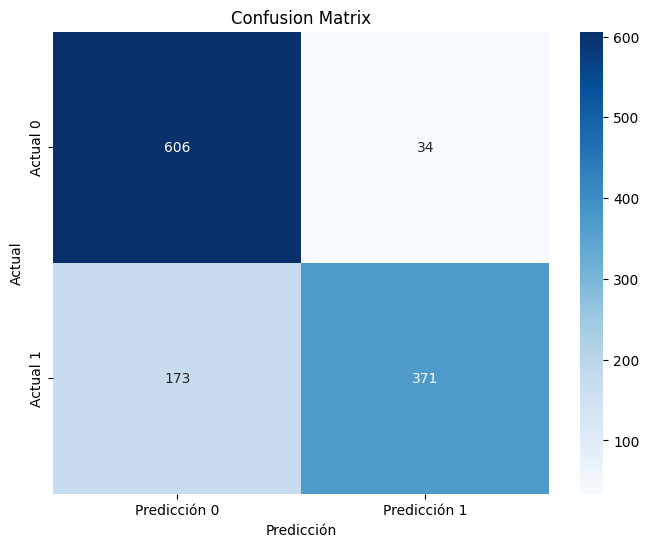

              precision    recall  f1-score   support

         0.0       0.78      0.95      0.85       640
         1.0       0.92      0.68      0.78       544

    accuracy                           0.83      1184
   macro avg       0.85      0.81      0.82      1184
weighted avg       0.84      0.83      0.82      1184



In [ ]:
y_pred = (model_cnn.predict(X_test) > 0.5).astype("int32")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicción 0', 'Predicción 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

En la matriz de confusión de la Red Neuronal Convolucional, podemos observar que hay un mejor rendimiento en comparación al MLP, sobre todo al observar las predicciones de clase muffin, los cuales presentan un mejor recall.

## Red Neuronal Convolucional 2.

Dado los resultados observados, lo primero que nos proponemos es corregir el sobreajuste, optimizando la convergencia del modelo a través de las épocas.

Para ello, utilizaremos exactamente el mismo modelo (tanto estructura como parámetros) pero añadiendo un método de regularización por Dropout en cada una de las capas. Esto nos permitirá apagar aleatoreamente neuronas durante el entrenamiento del modelo, evitando que el modelo aprenda de los ruidos del modelo y, por lo tanto, reduciendo el sobreajuste.

In [ ]:
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+2)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+4)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+5))
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_cnn.compile(loss='binary_crossentropy',
             optimizer = Adam(learning_rate=1e-2),
             metrics=['accuracy'])

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.7320 - loss: 0.6326 - val_accuracy: 0.6791 - val_loss: 1.1308
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8490 - loss: 0.3727 - val_accuracy: 0.8252 - val_loss: 0.5075
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8654 - loss: 0.3367 - val_accuracy: 0.7922 - val_loss: 0.5511
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8891 - loss: 0.2858 - val_accuracy: 0.7078 - val_loss: 0.8386
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8847 - loss: 0.2846 - val_accuracy: 0.8438 - val_loss: 0.4357
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9092 - loss: 0.2267 - val_accuracy: 0.7796 - val_loss: 0.4970
Epoch 7/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9240 - loss: 0.2029 - val_accuracy: 0.6909 - val_loss: 1.1294
Epoch 8/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9130 - loss: 0.2215 -

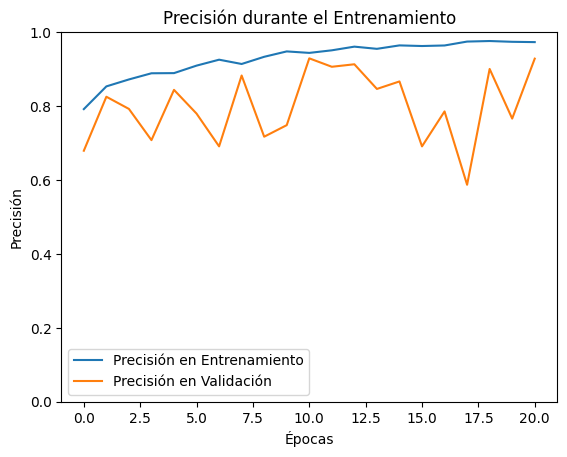

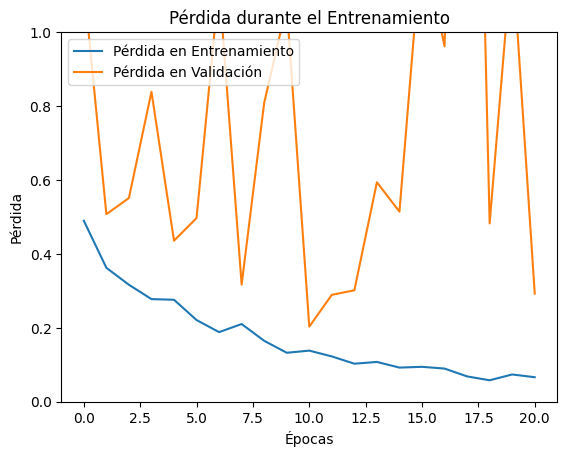

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
AUC del modelo: 0.9766


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
batch_size = 32
history = model_cnn.fit(
X_train, y_train,
batch_size=batch_size,
epochs=100,
verbose = 1,
validation_data=(X_test, y_test),
callbacks=[early_stopping]
)

# Evaluamos el modelo
train_acc=model_cnn.evaluate(X_train, y_train, batch_size=batch_size)[1]
test_acc=model_cnn.evaluate(X_test, y_test, batch_size=batch_size)[1]
print(f'Training accuracy: {train_acc:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

# Graficamos la precisión
plt.plot(history.history['accuracy'], label='Precisión en Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.ylim(0, 1)
plt.legend()
plt.title('Precisión durante el Entrenamiento')
plt.show()

# Graficamos la pérdida
plt.plot(history.history['loss'], label='Pérdida en Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.ylim(0, 1)
plt.legend()
plt.title('Pérdida durante el Entrenamiento')
plt.show()

# Evaluamos el modelo con AUC
y_pred_prob = model_cnn.predict(X_test)
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC del modelo: {auc:.4f}")

Este ejercicio arrojó excelentes resultados, dado que no sólo se logró reducir el sobreajuste a través de las épocas (las curvas de entrenamiento y validación convergen de mejor manera) sino que también se observa un aumento de la precisión (0.96) y del AUC (0.98).

Sin embargo, el modelo aún presenta un exceso de ruido o inestabilidad, mostrando grandes saltos a través de las épocas, por lo que debemos solucionar éste inconveniente.

**Matriz de Confusión y Classification Report**

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


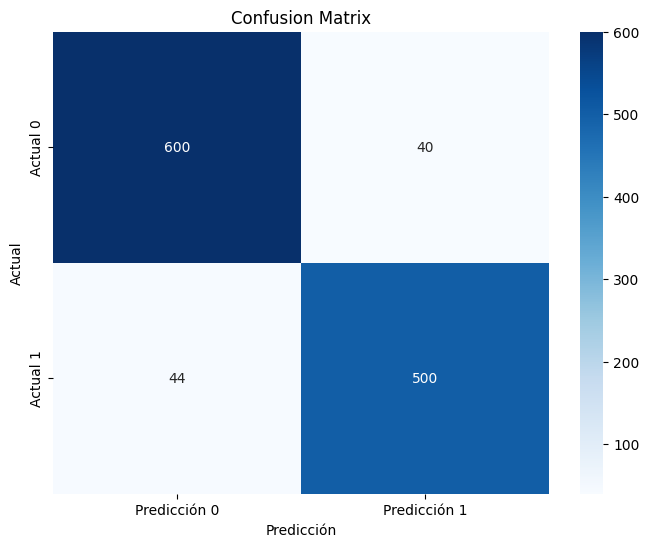

              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93       640
         1.0       0.93      0.92      0.92       544

    accuracy                           0.93      1184
   macro avg       0.93      0.93      0.93      1184
weighted avg       0.93      0.93      0.93      1184



In [ ]:
y_pred = (model_cnn.predict(X_test) > 0.5).astype("int32")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicción 0', 'Predicción 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

En la segunda CNN, podemos observar un cambio abrupto en el rendimiento respecto a la CNN anterior. Se observa un muy buen desempeño en todas las métricas, en este caso, precision, recall y f1-score, que están sobre el 90%.

## Red Neuronal Convolucional 3.

Dado que el modelo anterior mostraba inconvenientes con el exceso de ruido, éste tercer modelo se centrará mejorar la estabilidad.

Para ello, no realizamos modificaciones en la estructura del modelo, sino que ajustamos los hiperparámetros de compilación y entrenamiento. Específicamente disminuimos el learning rate a 0.0001, con el fin de evitar que el modelo de 'pasos' demasiado grandes a través de las épocas; Y aumentamos el batch size a 512, con el fin de entregar más datos al modelo cuando actualiza los pesos. En combinación, ambas medidas debería ayudarnos a reducir el ruido y mejorar la estabilidad.

Adicionalmente, se aumenta la paciencia en 'Early Stopping' a 20 épocas, dado que con éstos ajustes el modelo podría tardar mucho más en converger.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6103 - loss: 0.8248 - val_accuracy: 0.5659 - val_loss: 1.2960
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 393ms/step - accuracy: 0.7591 - loss: 0.5602 - val_accuracy: 0.6976 - val_loss: 0.6160
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 429ms/step - accuracy: 0.8084 - loss: 0.4921 - val_accuracy: 0.6258 - val_loss: 0.7585
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 429ms/step - accuracy: 0.8256 - loss: 0.4474 - val_accuracy: 0.7019 - val_loss: 0.6130
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 427ms/step - accuracy: 0.8426 - loss: 0.4060 - val_accuracy: 0.6850 - val_loss: 0.6602
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 411ms/step - accuracy: 0.8396 - loss: 0.4008 - val_accuracy: 0.7230 - val_loss: 0.5670
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 399ms/step - accuracy: 0.8508 - loss: 0.3857 - val_accuracy: 0.6926 - val_loss: 0.6127
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 403ms/step - accuracy: 0.8537 - loss: 0.3650 - val_accura

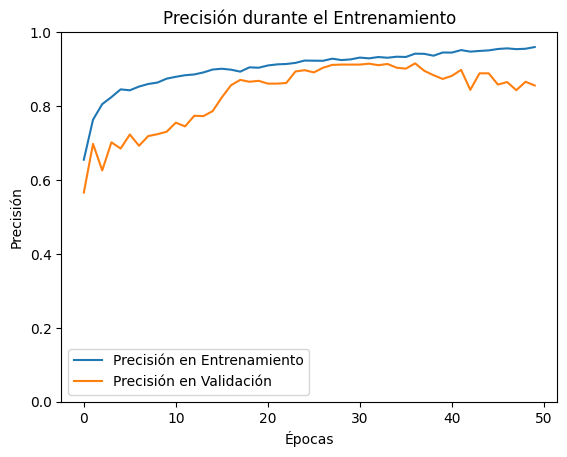

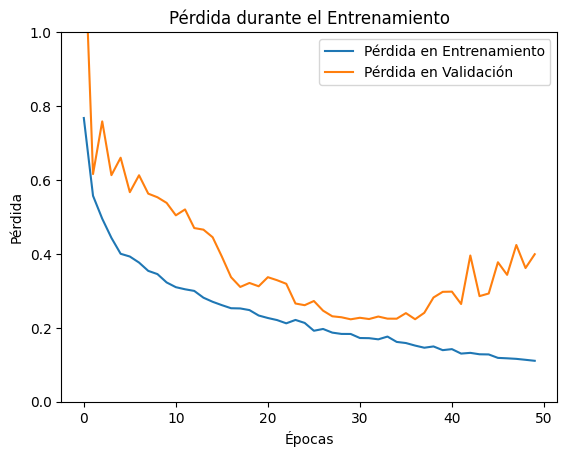

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
AUC del modelo: 0.9689


In [ ]:
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+2)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+4)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+5))
])

model_cnn.compile(loss='binary_crossentropy',
             optimizer = Adam(learning_rate=1e-4), #Se ajusta learning rate
             metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True) # Se aumenta la paciencia en función de las modificaciones.
batch_size = 512 # Se incrementa el batch size
history = model_cnn.fit(
X_train, y_train,
batch_size=batch_size,
epochs=100,
verbose = 1,
validation_data=(X_test, y_test),
callbacks=[early_stopping]
)

# Evaluamos el modelo
train_acc=model_cnn.evaluate(X_train, y_train, batch_size=batch_size)[1]
test_acc=model_cnn.evaluate(X_test, y_test, batch_size=batch_size)[1]
print(f'Training accuracy: {train_acc:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

# Graficamos la precisión
plt.plot(history.history['accuracy'], label='Precisión en Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.ylim(0, 1)
plt.legend()
plt.title('Precisión durante el Entrenamiento')
plt.show()

# Graficamos la pérdida
plt.plot(history.history['loss'], label='Pérdida en Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.ylim(0, 1)
plt.legend()
plt.title('Pérdida durante el Entrenamiento')
plt.show()

# Evaluamos el modelo con AUC
y_pred_prob = model_cnn.predict(X_test)
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC del modelo: {auc:.4f}")

Los gráficos de pérdida de entrenamiento y testeo muestran un excelente resultado en función de lo que buscábamos, puesto que las curvas de validación se observan mucho más estables.

De esta manera, obtenemos un modelo que además de presentar una excelente precisión (0.93), también presenta un excelente rendimiento general (AUC 0.97) y una correcta estabilidad. Sin embargo, todavía se observa un ligero sobreajuste (muy ligero, éste desajuste podría considerarse como algo normal y aceptable inclusive), por lo que nos proponemos como desafío intentar seguir mejorándolo.  

**Matriz de Confusión y Classification Report**

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


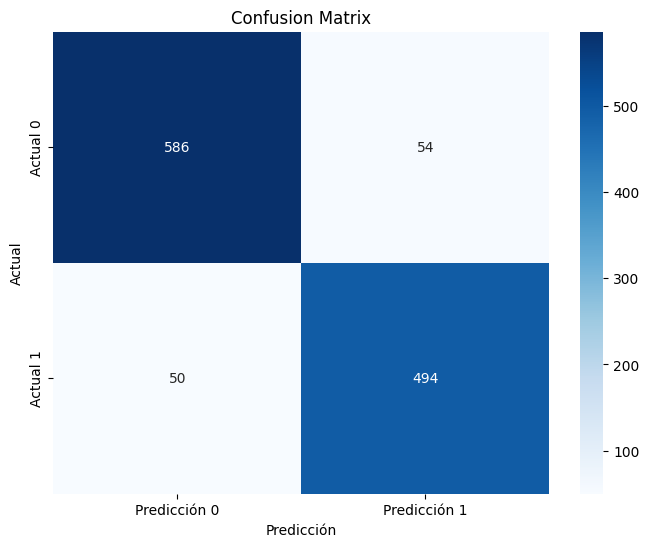

              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92       640
         1.0       0.90      0.91      0.90       544

    accuracy                           0.91      1184
   macro avg       0.91      0.91      0.91      1184
weighted avg       0.91      0.91      0.91      1184



In [ ]:
y_pred = (model_cnn.predict(X_test) > 0.5).astype("int32")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicción 0', 'Predicción 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

Si bien las métricas son muy similares a la CNN anterior, se valora la mejora en la estabilidad del modelo en el entrenamiento.

## Red Neuronal Convolucional 4.

Para este cuarto modelo, aplicamos una medida muy sencilla con el fin de empujar un poco más la mejora en el ajuste: Simplificarlo.

Para ello, simplemente se removió la cuarta capa convolucional, manteniendo los mismos criterios para el resto de la estructura y parámetros de compilación/entrenamiento.  

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6409 - loss: 0.8249 - val_accuracy: 0.5726 - val_loss: 2.3601
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 397ms/step - accuracy: 0.8032 - loss: 0.5047 - val_accuracy: 0.7787 - val_loss: 0.6333
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 395ms/step - accuracy: 0.8336 - loss: 0.4183 - val_accuracy: 0.7306 - val_loss: 0.7333
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.8506 - loss: 0.3793 - val_accuracy: 0.7897 - val_loss: 0.5349
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 400ms/step - accuracy: 0.8672 - loss: 0.3393 - val_accuracy: 0.7948 - val_loss: 0.4893
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 378ms/step - accuracy: 0.8701 - loss: 0.3163 - val_accuracy: 0.8015 - val_loss: 0.4591
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 359ms/step - accuracy: 0.8934 - loss: 0.2850 - val_accuracy: 0.7973 - val_loss: 0.4416
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 386ms/step - accuracy: 0.8931 - loss: 0.2753 - val_accur

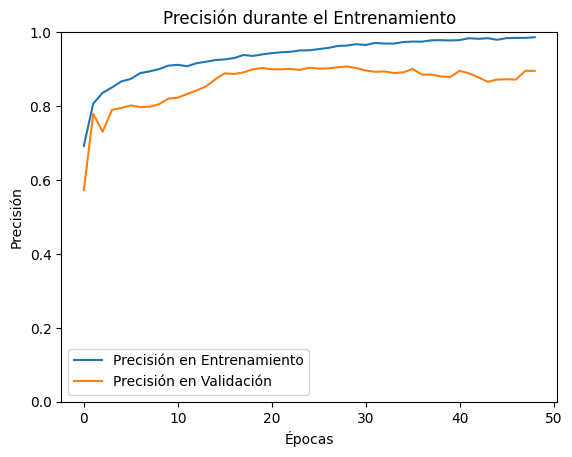

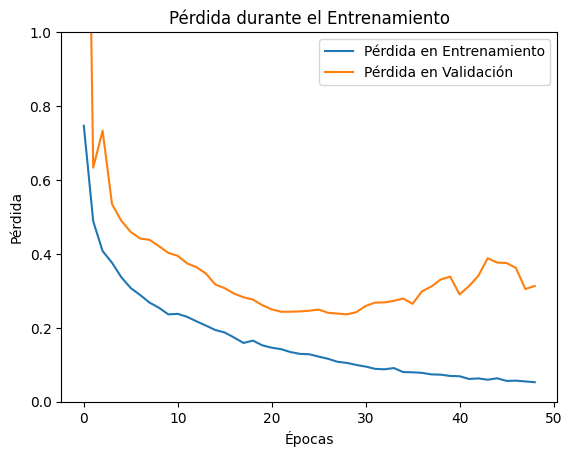

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
AUC del modelo: 0.9660


In [ ]:
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+2)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+3)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+4))
])

model_cnn.compile(loss='binary_crossentropy',
             optimizer = Adam(learning_rate=1e-4),
             metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
batch_size = 512
history = model_cnn.fit(
X_train, y_train,
batch_size=batch_size,
epochs=100,
verbose = 1,
validation_data=(X_test, y_test),
callbacks=[early_stopping]
)

# Evaluamos el modelo
train_acc=model_cnn.evaluate(X_train, y_train, batch_size=batch_size)[1]
test_acc=model_cnn.evaluate(X_test, y_test, batch_size=batch_size)[1]
print(f'Training accuracy: {train_acc:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

# Graficamos la precisión
plt.plot(history.history['accuracy'], label='Precisión en Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.ylim(0, 1)
plt.legend()
plt.title('Precisión durante el Entrenamiento')
plt.show()

# Graficamos la pérdida
plt.plot(history.history['loss'], label='Pérdida en Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.ylim(0, 1)
plt.legend()
plt.title('Pérdida durante el Entrenamiento')
plt.show()

# Evaluamos el modelo con AUC
y_pred_prob = model_cnn.predict(X_test)
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC del modelo: {auc:.4f}")

Si bien los resultados obtenidos son muy buenos, siguen siendo ligeramente peores al modelo anterior, dado que no presenta mejorías en el rendimiento general y el ajuste es peor.

Por este motivo, no consideraremos las modificaciones realizadas en esta instancia para los modelos que desarrollaremos posteriormente.

**Matriz de Confusión y Classification Report**

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


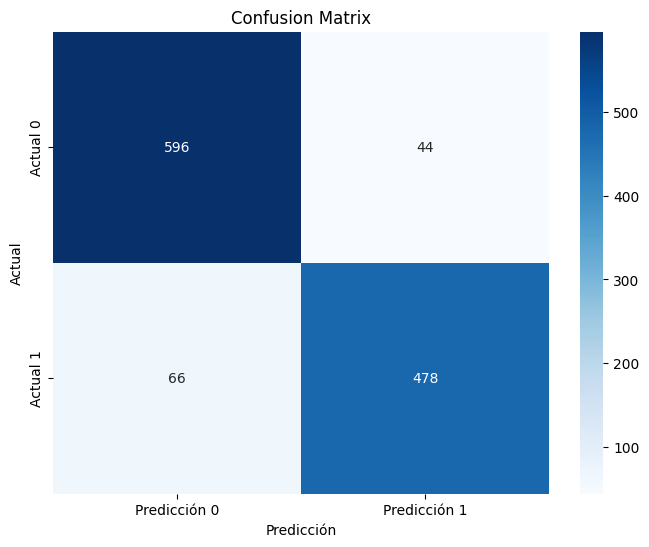

              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92       640
         1.0       0.92      0.88      0.90       544

    accuracy                           0.91      1184
   macro avg       0.91      0.90      0.91      1184
weighted avg       0.91      0.91      0.91      1184



In [ ]:
y_pred = (model_cnn.predict(X_test) > 0.5).astype("int32")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicción 0', 'Predicción 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

En la cuarta CNN, observamos un rendimiento ligeramente inferior a la CNN anterior. El recall en clase 1 decae a un 88%.

## Red Neuronal Convolucional 5.

Para este quinto modelo, y en función de intentar mejorar el ajuste, añadiremos un método de regularización L2, el cual tendrá un valor muy bajo (0.0001) dado que el sobreajuste es muy ligero, y al hecho de que tampoco queremos empeorar los valores de pérdida.

Nota: Se ha observado que valores muy altos de regularización L2 aumenta considerablemente la pérdida en entrenamiento y validación.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6209 - loss: 0.9196 - val_accuracy: 0.5693 - val_loss: 1.3942
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 397ms/step - accuracy: 0.7623 - loss: 0.6280 - val_accuracy: 0.5802 - val_loss: 1.0953
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 418ms/step - accuracy: 0.8000 - loss: 0.5871 - val_accuracy: 0.7221 - val_loss: 0.6284
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 398ms/step - accuracy: 0.8179 - loss: 0.5005 - val_accuracy: 0.6900 - val_loss: 0.7574
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 390ms/step - accuracy: 0.8341 - loss: 0.4881 - val_accuracy: 0.7348 - val_loss: 0.6651
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 409ms/step - accuracy: 0.8486 - loss: 0.4461 - val_accuracy: 0.7517 - val_loss: 0.5898
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 400ms/step - accuracy: 0.8541 - loss: 0.4489 - val_accuracy: 0.7356 - val_loss: 0.6226
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 414ms/step - accuracy: 0.8589 - loss: 0.4162 - val_accura

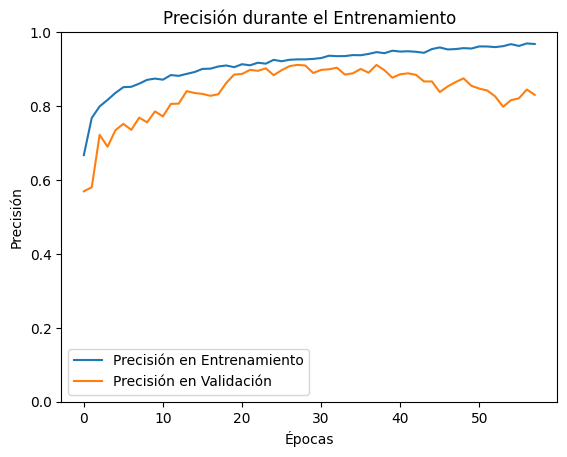

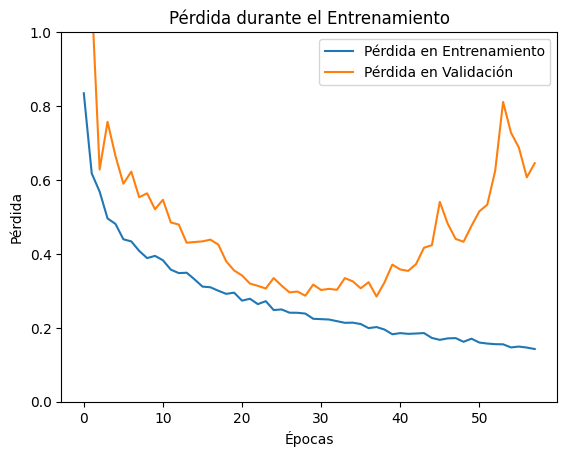

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
AUC del modelo: 0.9695


In [ ]:
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed), kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+1), kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+2), kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+3), kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+4), kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+5), kernel_regularizer=l2(0.0001))
])

model_cnn.compile(loss='binary_crossentropy',
             optimizer = Adam(learning_rate=1e-4),
             metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
batch_size = 512
history = model_cnn.fit(
X_train, y_train,
batch_size=batch_size,
epochs=100,
verbose = 1,
validation_data=(X_test, y_test),
callbacks=[early_stopping]
)

# Evaluamos el modelo
train_acc=model_cnn.evaluate(X_train, y_train, batch_size=batch_size)[1]
test_acc=model_cnn.evaluate(X_test, y_test, batch_size=batch_size)[1]
print(f'Training accuracy: {train_acc:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

# Graficamos la precisión
plt.plot(history.history['accuracy'], label='Precisión en Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.ylim(0, 1)
plt.legend()
plt.title('Precisión durante el Entrenamiento')
plt.show()

# Graficamos la pérdida
plt.plot(history.history['loss'], label='Pérdida en Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.ylim(0, 1)
plt.legend()
plt.title('Pérdida durante el Entrenamiento')
plt.show()

# Evaluamos el modelo con AUC
y_pred_prob = model_cnn.predict(X_test)
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC del modelo: {auc:.4f}")

Lamentablemente, no se obsevan mejoras significativas en el ajuste del modelo, adicionalmente el rendimiento general tampoco presenta mejorías, por lo que descartamos los ajustes realizados.  

**Matriz de Confusión y Classification Report**

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


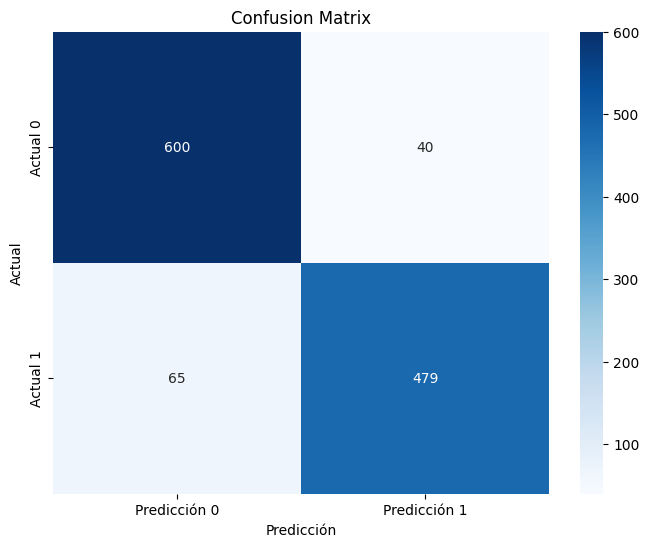

              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       640
         1.0       0.92      0.88      0.90       544

    accuracy                           0.91      1184
   macro avg       0.91      0.91      0.91      1184
weighted avg       0.91      0.91      0.91      1184



In [ ]:
y_pred = (model_cnn.predict(X_test) > 0.5).astype("int32")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicción 0', 'Predicción 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

En la quinta CNN, observamos un rendimiento ligeramente inferior a la 3 CNN. Nuevamente el recall en clase 1 decae a un 88%.

## Red Neuronal Convolucional 6.

Para este sexto modelo, cambiaremos un poco el enfoque. A continuación lo que nos planteamos como desafío buscar una mejora en la precisión y el rendimiento general, explorando la importancia que podría tener para nuestro modelo los datos que provienen de los contornos de las imágenes.

Por ello, modificamos ligeramente la estructura del modelo, añadiendo 'padding' en cada una de las capas convolucionales.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6383 - loss: 0.7752 - val_accuracy: 0.7551 - val_loss: 0.5305
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 450ms/step - accuracy: 0.7946 - loss: 0.5201 - val_accuracy: 0.6512 - val_loss: 0.7235
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 463ms/step - accuracy: 0.8194 - loss: 0.4599 - val_accuracy: 0.7483 - val_loss: 0.5510
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 476ms/step - accuracy: 0.8425 - loss: 0.4047 - val_accuracy: 0.7551 - val_loss: 0.5433
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 478ms/step - accuracy: 0.8525 - loss: 0.3828 - val_accuracy: 0.7720 - val_loss: 0.5146
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 458ms/step - accuracy: 0.8672 - loss: 0.3407 - val_accuracy: 0.7669 - val_loss: 0.5136
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 478ms/step - accuracy: 0.8777 - loss: 0.3279 - val_accuracy: 0.7584 - val_loss: 0.5143
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 469ms/step - accuracy: 0.8778 - loss: 0.3304 - val_accura

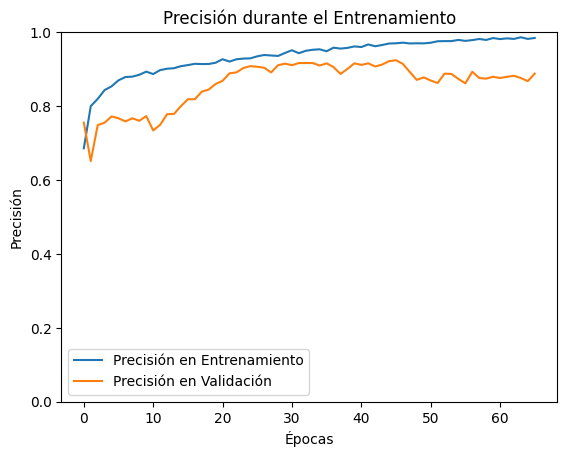

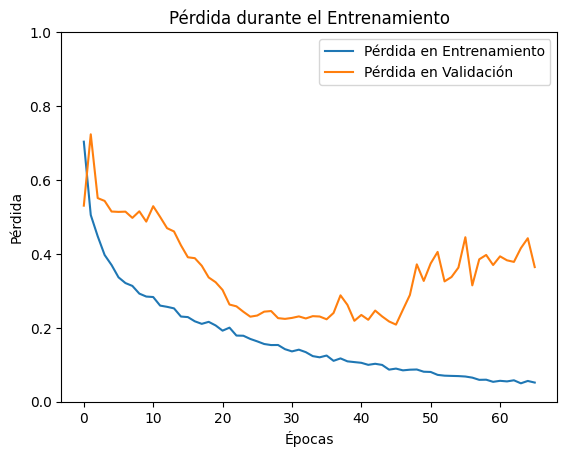

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
AUC del modelo: 0.9760


In [ ]:
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+1), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+2), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+4)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+5))
])


model_cnn.compile(loss='binary_crossentropy',
             optimizer = Adam(learning_rate=1e-4),
             metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
batch_size = 512
history = model_cnn.fit(
X_train, y_train,
batch_size=batch_size,
epochs=100,
verbose = 1,
validation_data=(X_test, y_test),
callbacks=[early_stopping]
)

# Evaluamos el modelo
train_acc=model_cnn.evaluate(X_train, y_train, batch_size=batch_size)[1]
test_acc=model_cnn.evaluate(X_test, y_test, batch_size=batch_size)[1]
print(f'Training accuracy: {train_acc:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

# Graficamos la precisión
plt.plot(history.history['accuracy'], label='Precisión en Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.ylim(0, 1)
plt.legend()
plt.title('Precisión durante el Entrenamiento')
plt.show()

# Graficamos la pérdida
plt.plot(history.history['loss'], label='Pérdida en Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.ylim(0, 1)
plt.legend()
plt.title('Pérdida durante el Entrenamiento')
plt.show()

# Evaluamos el modelo con AUC
y_pred_prob = model_cnn.predict(X_test)
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC del modelo: {auc:.4f}")

En general los resultados son muy buenos, aunque no logran constituir una mejoría significativa en precisión y rendimiento general (AUC). Por lo demás, el modelo empeora ligeramente en ajuste (sobreajuste) a partir de la pérdida de validación, por lo cual descartamos éste método como forma de optimizar el desempeño.

**Matriz de Confusión y Classification Report**

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


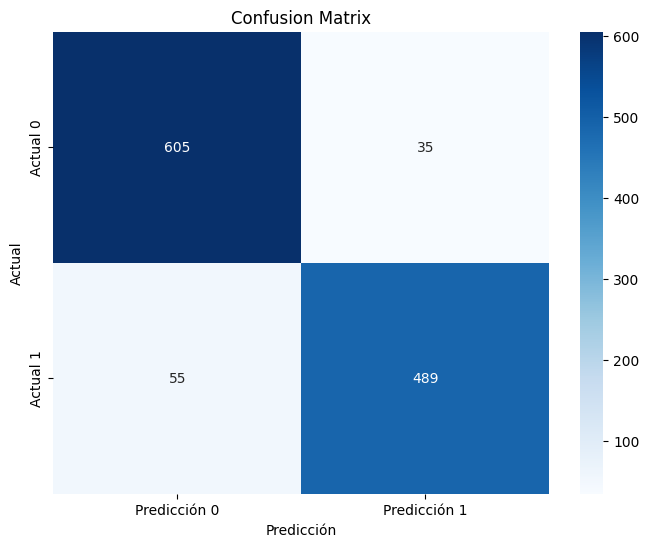

              precision    recall  f1-score   support

         0.0       0.92      0.95      0.93       640
         1.0       0.93      0.90      0.92       544

    accuracy                           0.92      1184
   macro avg       0.92      0.92      0.92      1184
weighted avg       0.92      0.92      0.92      1184



In [ ]:
y_pred = (model_cnn.predict(X_test) > 0.5).astype("int32")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicción 0', 'Predicción 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

En general el modelo presenta buenos resultados en todas sus métricas, pero dado que se pierde ajustes en las curvas de pérdida, no lo consideraremos para posteriores modelos.

*Nota: En general ambos modelos (CNN 3 y CNN 6) podrían ser perfectamente válidos.*

## Red Neuronal Convolucional 7.

Finalmente, exploraremos el uso de 'data augmentation' como una forma de intentar reducir el leve sobreajuste aún presente en el entrenamiento y, de ser posible, mejorar aún más la precisión y rendimiento general.

Para ell se añaden rotaciones y desplazamientos de una misma imagen, lo que podría aumentar la capacidad de generalizar del modelo.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.6109 - loss: 0.8583 - val_accuracy: 0.5498 - val_loss: 1.1775
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 687ms/step - accuracy: 0.7168 - loss: 0.6499 - val_accuracy: 0.6486 - val_loss: 0.7741
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 875ms/step - accuracy: 0.7653 - loss: 0.5870 - val_accuracy: 0.7078 - val_loss: 0.6318
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 874ms/step - accuracy: 0.7840 - loss: 0.5514 - val_accuracy: 0.7390 - val_loss: 0.5457
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 784ms/step - accuracy: 0.7991 - loss: 0.4897 - val_accuracy: 0.7492 - val_loss: 0.5373
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8101 - loss: 0.4953 - val_accuracy: 0.7525 - val_loss: 0.5224
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 997ms/step - accuracy: 0.8263 - loss: 0.4598 - val_accuracy: 0.7407 - val_loss: 0.5636
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8326 - loss: 0.4483 - val_accuracy: 0.7576 - val_l

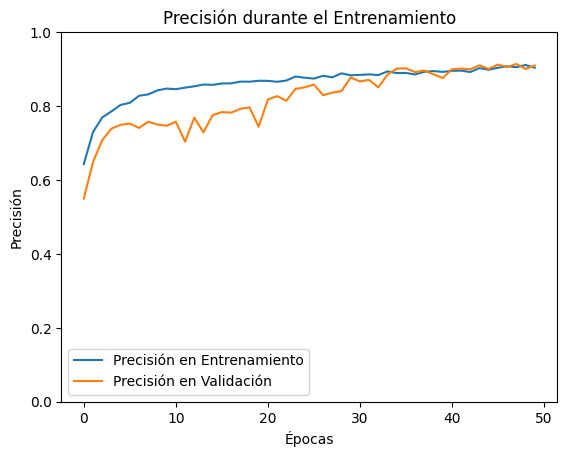

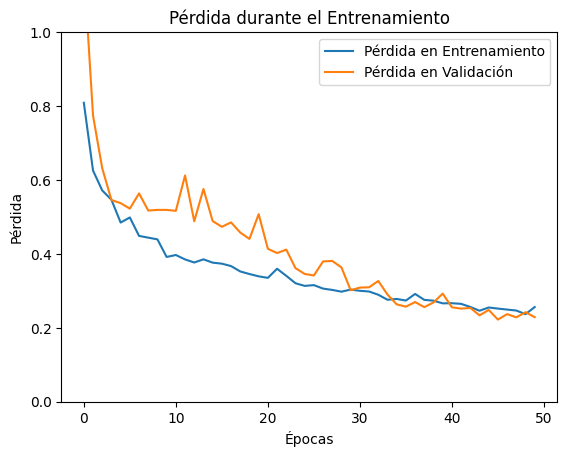

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
AUC del modelo: 0.9689


In [ ]:
# Configuración de data augmentation
batch_size = 512
datagen = ImageDataGenerator(
    rotation_range=20,         # Rotar imágenes hasta 20 grados
    width_shift_range=0.2,     # Desplazar horizontalmente
    height_shift_range=0.2,    # Desplazar verticalmente
    shear_range=0.2,           # Aplicar cizalladura
    zoom_range=0.2,            # Hacer zoom
    horizontal_flip=True,      # Invertir horizontalmente
    fill_mode='nearest'        # Método para rellenar píxeles faltantes
)

# Cargar datos y aplicar las transformaciones
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+2)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+4)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed+5))
])

model_cnn.compile(loss='binary_crossentropy',
             optimizer = Adam(learning_rate=1e-4), #Se ajusta learning rate
             metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True) # Se aumenta la paciencia en función de las modificaciones.

history = model_cnn.fit(
train_generator,
batch_size=batch_size,
epochs=50,
verbose = 1,
validation_data=(X_test, y_test),
callbacks=[early_stopping]
)

# Evaluamos el modelo
train_acc=model_cnn.evaluate(X_train, y_train, batch_size=batch_size)[1]
test_acc=model_cnn.evaluate(X_test, y_test, batch_size=batch_size)[1]
print(f'Training accuracy: {train_acc:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

# Graficamos la precisión
plt.plot(history.history['accuracy'], label='Precisión en Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.ylim(0, 1)
plt.legend()
plt.title('Precisión durante el Entrenamiento')
plt.show()

# Graficamos la pérdida
plt.plot(history.history['loss'], label='Pérdida en Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.ylim(0, 1)
plt.legend()
plt.title('Pérdida durante el Entrenamiento')
plt.show()

# Evaluamos el modelo con AUC
y_pred_prob = model_cnn.predict(X_test)
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC del modelo: {auc:.4f}")


De esta manera, observamos que nuestro modelo logra converger correctamente, se estabiliza y ya no muestra sobreajuste a través de las épocas.

Adicionalmente, registra una excelente precisión (0.92) que si bien es algo menor a otros modelos observados anteriormente, es un 'sacrificio' aceptable en función de mejorar el ajuste general. Finalmente, cabe destacar que el modelo obtiene un AUC de 0.97, lo que indica que mantiene un excelente rendimiento general.  

**Matriz de Confusión y Classification Report**

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


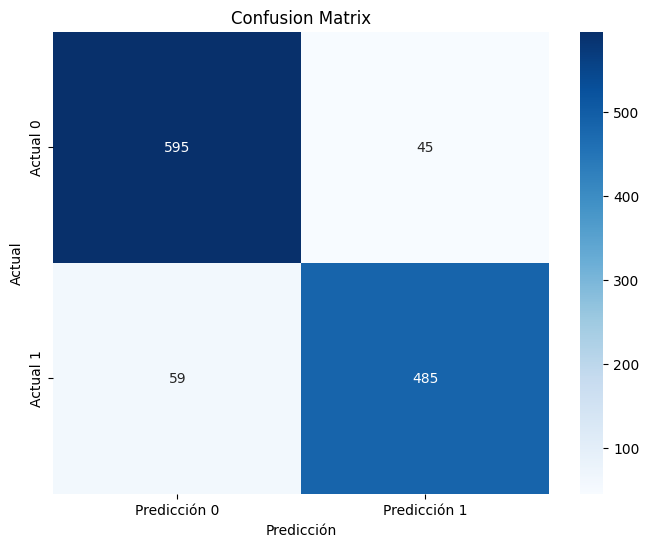

              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92       640
         1.0       0.92      0.89      0.90       544

    accuracy                           0.91      1184
   macro avg       0.91      0.91      0.91      1184
weighted avg       0.91      0.91      0.91      1184



In [ ]:
y_pred = (model_cnn.predict(X_test) > 0.5).astype("int32")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicción 0', 'Predicción 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

Dado que la matriz mantiene buenas métricas (precision, recall, f1-score), podemos definir este como el mejor modelo, dado que además, presenta mejor ajuste, estabilidad y rendimiento.

## 6. Comparación de Modelos

En el laboratorio presentamos la construcción y evaluación de varios modelos para la clasificación de imágenes de muffins y chihuahuas. Se utilizaron dos tipos principales de modelos:

Perceptrón Multicapa (MLP): Este modelo, al ser una red neuronal tradicional, tuvo dificultades para capturar las características complejas de las imágenes, resultando en un rendimiento aceptable, pero con un margen considerable de mejora.

Redes Neuronales Convolucionales (CNN): Se desarrollaron varias arquitecturas CNN, buscando mejorar la precisión y el ajuste del modelo.

*   CNN 1: La primera arquitectura CNN, si bien logró una alta precisión en el entrenamiento, presentó un problema de sobreajuste, indicando que no generalizaba bien a datos nuevos.
*   CNN 2: Se incorporó la técnica de Dropout para controlar el sobreajuste, logrando una mejora en la generalización del modelo y un mejor rendimiento en el conjunto de prueba, pero manteniendo un alto nivel de ruido en las funciones de pérdida.

*   CNN 3: Se ajustaron el learning rate y el batch size para controlar el ruido y mejorar la estabilidad del modelo, resultando en un modelo con un buen equilibrio entre precisión y ajuste.

*   CNN 4, 5, 6: Se exploraron otras modificaciones como la reducción de capas, la regularización L2 y el uso de padding. Sin embargo, estas modificaciones no lograron superar el rendimiento de la CNN 3.
*   CNN 7: Se incorporó data augmentation, que consiste en aplicar transformaciones a las imágenes de entrenamiento para aumentar la cantidad de datos y mejorar la capacidad de generalización del modelo. Esto ayudó a reducir el sobreajuste y mejoró el rendimiento general.

## Modelo con el mejor rendimiento

El mejor modelo fue la CNN 7 (con data augmentation). Esta arquitectura, junto con las técnicas de regularización y los ajustes de hiperparámetros, logró un buen equilibrio entre precisión, ajuste y estabilidad.

### Razones para destacar la CNN 7:

*   **Mejor rendimiento general**: Obtuvo un destacable AUC, lo que indica un buen poder de discriminación entre las clases.

*  **Control del sobreajuste**: Gracias al Dropout y al data augmentation, se minimizó el sobreajuste, logrando una mejor generalización.

*   **Control de Estabilidad**: El modelo logra converger en sus funciones de pérdida y también precisión, manteniendo al mismo tiempo, bajos niveles de ruido.





### Imágenes clasificadas erróneamente

In [ ]:
def plot_images_in_grid(images, titles, n_examples=10, n_rows=2, figsize=(15, 5)):
    """
    Generaliza la creación de una grilla para mostrar imágenes.

    Parameters:
    - images: Lista de imágenes a mostrar.
    - titles: Lista de títulos para cada imagen.
    - n_examples: Número máximo de ejemplos a mostrar.
    - n_rows: Número de filas en la grilla.
    - figsize: Tamaño de la figura (tupla).
    """
    n_cols = (n_examples + n_rows - 1) // n_rows
    fig, ax = plt.subplots(n_rows, n_cols, figsize=figsize)

    ax = ax.flatten() if n_rows > 1 else [ax]

    for idx in range(len(ax)):
        if idx < n_examples and idx < len(images):
            ax[idx].imshow(images[idx])
            ax[idx].set_title(titles[idx])
            ax[idx].axis('off')
        else:
            ax[idx].axis('off')

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()

Ejemplos de clasificaciones erróneas en el mejor modelo (segundo modelo convolucional)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


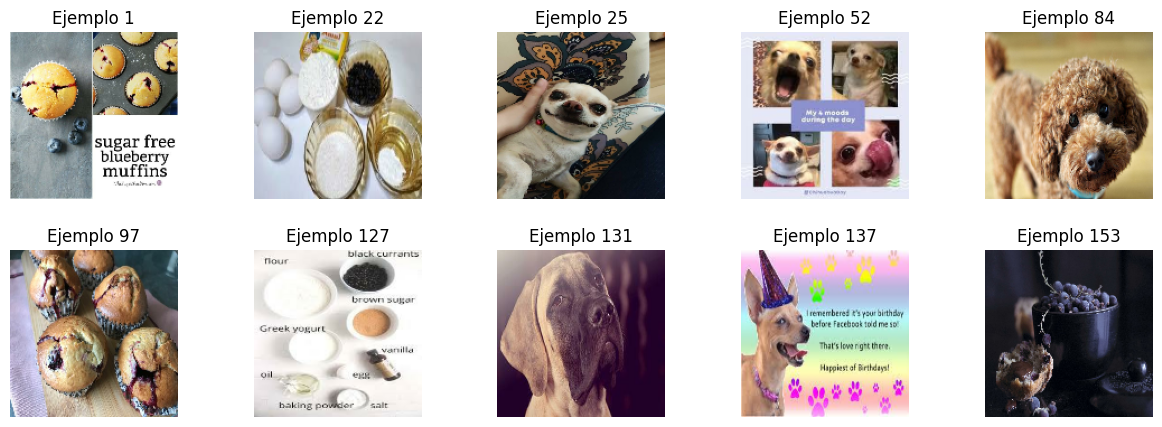

In [ ]:
n_examples = 10
n_rows = 2
y_pred_cnn = (model_cnn.predict(X_test) > 0.5).astype("int32")

# Filtramos imágenes y títulos
filtered_images = [X_test[i] / 255 for i in range(len(y_test)) if y_pred_cnn[i] != y_test[i]]
filtered_titles = [f'Ejemplo {i}' for i in range(len(y_test)) if y_pred_cnn[i] != y_test[i]]

filtered_images = filtered_images[:n_examples]
filtered_titles = filtered_titles[:n_examples]

plot_images_in_grid(filtered_images, filtered_titles, n_examples=n_examples, n_rows=n_rows)


Se puede ver la gran dificultad para la clasificación en las imágenes mostrados para el modelo con mejor desempeño. Ejemplos como el 131 y 84 son otros tipos de perro presentes en el dataset, los cuales es razonable que el modelo no los pueda clasificar correctamente. Ejemplos como el 22, 127 y el 153 son ingredientes similares a muffins, pero muy diferentes a la apariencia habitual de los muffins. Ejemplos como el 52 y 137 son chihuahuas, pero con texto en la imagen, lo cual puede complejizar su correcta clasificación

## 7. Conclusiones

Se puede concluir un cumplimiento de los objetivos planteados para este laboratorio. Se logra entrenar un modelo de red convolucional capaz de clasificar en el dataset de chihuahuas vs muffins. Adicionalmente, se logra explorar diferentes configuraciones con el fin de obtener el mejor rendimiento.

Se concluye la importancia de la red convolucional en su **extracción automática de características**, a diferencia del enfoque clásico de Machine Learning, ya que esto es clave para captar características locales en la imagen. Lo anterior se pudo constatar en el rendimiento sobresaliente de la red convolucional sobre un modelo simple de perceptrón multi-capa.

Se concluye la importancia de un correcto ajuste de hiperparámetros en la red convolucional. Un tamaño de batch y tasa de aprendizaje incorrectos pueden conducir a funciones de pérdidas muy erráticas e inestables. De la misma forma se desprende la utilidad del dropout y la técnica de data augmentation para reducir considerablemente el overfitting en la red convolucional. De esta forma logramos crear un modelo que no sólo tiene un buen rendimiento, sino que también nos enfocamos en no perder de vista otros aspectos como lo son el ajuste, la estabilidad y la precisión.